In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [2]:
train=pd.read_csv('train_2.csv')
key=pd.read_csv('key_2.csv')

In [3]:
train[["topic","lang","access","type"]]=train["Page"].str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')

## Data preperation

### Applying log transformation

In [4]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [5]:
data=train.select_dtypes(exclude='O').fillna(0)

In [6]:
data=log(data)

In [7]:
features=train.select_dtypes(exclude='number')
features=features.drop(features[['Page','topic',]],axis=1)

## Numerical features

In [8]:
stats_feats=pd.DataFrame()
stats_feats['mean']=np.mean(data,axis=1)
stats_feats['median']=np.median(data,axis=1)
stats_feats['std']=np.std(data,axis=1)

stats_feats['percentile_25']=np.quantile(data,axis=1,q=0.25)
stats_feats['percentile_50']=np.quantile(data,axis=1,q=0.50)
stats_feats['percentile_75'] =np.quantile(data,axis=1,q=0.75)
stats_feats['percentile_90'] = np.quantile(data,axis=1,q=0.90)

stats_feats["Kurt"] = stats.kurtosis(data,axis=1)
stats_feats["skewness"] = stats.skew(data,axis=1)

## Handling categorical features

In [9]:
def handling_cat_features(df):
    le=LabelEncoder()
    cat_features=df.apply(le.fit_transform)
    return cat_features


handled_cat_features=handling_cat_features(features)

In [10]:
def reshape(df):
    return df.reshape((df.shape[0],df.shape[1],1))

def prepare_data(train,x_length,y_length,moving_window=32):
    
    #train_x_dates = train.iloc[:,-x_length-y_length:-y_length].columns
    #train_y_dates = train.iloc[:,-y_length:].columns
    train_x = reshape(train.iloc[:,-x_length-y_length-32:-y_length-32].values)
    train_y = reshape(train.iloc[:,-y_length-32:-32].values)
    
    val_x = reshape(train.iloc[:,-x_length-y_length:-y_length].values)
    val_y = reshape(train.iloc[:,-y_length:].values)
    
    test_x = reshape(train.iloc[:,-x_length:].values)
   
    return train_x,train_y,val_x,val_y,test_x


In [11]:
x_length=100 #taking last 100 years
y_length=64 #to predict the next 64 days

In [12]:
train_x,train_y,val_x,val_y,test_x=prepare_data(data,100,64)

In [18]:
import tensorflow.keras.backend as K 
def k_smape(y_true,y_pred):
    diff = K.abs((y_true-y_pred)/K.clip(K.abs(y_true) + K.abs(y_pred),K.epsilon(),None))
    return 200.0*K.mean(diff,axis=-1)

## Training CNN1D

In [53]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, TimeDistributed
from tensorflow.keras.layers import Dropout,Flatten
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [36]:
model=Sequential()

model.add(Conv1D(128,kernel_size=3,input_shape=(x_length,1),activation='relu'))
model.add(Conv1D(64,activation='relu',kernel_size=3))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64))

In [37]:
model.compile(optimizer=Adam(), metrics=[k_smape],loss='mean_absolute_error')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 98, 128)           512       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 96, 64)            24640     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                196672    
Total params: 221,824
Trainable params: 221,824
Non-trainable params: 0
________________________________________________

In [44]:
history=model.fit(train_x,train_y,epochs=20,batch_size=100,validation_data=(val_x,val_y))

Epoch 1/20
1451/1451 [==============================] - 86s 60ms/step - loss: 0.1606 - k_smape: 18.7528 - val_loss: 0.1736 - val_k_smape: 19.8059
Epoch 2/20
1451/1451 [==============================] - 86s 59ms/step - loss: 0.1605 - k_smape: 18.7618 - val_loss: 0.1770 - val_k_smape: 19.6625
Epoch 3/20
1451/1451 [==============================] - 68s 47ms/step - loss: 0.1602 - k_smape: 18.7497 - val_loss: 0.1729 - val_k_smape: 19.2825
Epoch 4/20
1451/1451 [==============================] - 78s 54ms/step - loss: 0.1602 - k_smape: 18.7396 - val_loss: 0.1769 - val_k_smape: 19.9294
Epoch 5/20
1451/1451 [==============================] - 67s 46ms/step - loss: 0.1602 - k_smape: 18.7418 - val_loss: 0.1713 - val_k_smape: 19.3775
Epoch 6/20
1451/1451 [==============================] - 67s 46ms/step - loss: 0.1601 - k_smape: 18.7392 - val_loss: 0.1712 - val_k_smape: 19.2522
Epoch 7/20
1451/1451 [==============================] - 67s 46ms/step - loss: 0.1601 - k_smape: 18.7348 - val_loss: 0.1706 -

In [45]:
score=model.evaluate(val_x,val_y,verbose=0)

print('Symmetric Mean Absolute Percentage Error is: ', score[1])

Symmetric Mean Absolute Percentage Error is:  20.039730072021484


In [47]:
#This function is used to update the plots for each epoch and error
def plt_dynamic(x,vy,ty,ax,colors=['b']):
  ax.plot(x,vy,'b',label='Validation Loss')
  ax.plot(x,ty,'r',label='Train loss')
  plt.legend()
  plt.grid()
  fig.canvas.draw()

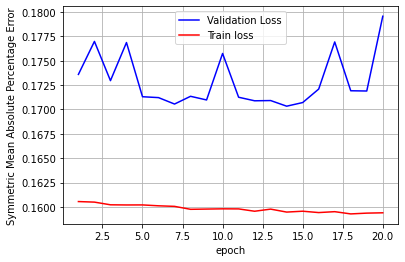

In [49]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,1)
ax.set_xlabel('epoch');ax.set_ylabel('Symmetric Mean Absolute Percentage Error')

x=list(range(1,20+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## Training LSTM model

In [65]:
lstm_model=Sequential()
lstm_model.add(LSTM(128,activation='relu',input_shape=(None,1)))
lstm_model.add(Dense(64,activation='relu'))
lstm_model.add(Flatten())
lstm_model.add(Dense(1,activation='linear'))

In [66]:
lstm_model.compile(optimizer=Adam(),metrics=[k_smape],loss='mean_absolute_error')
lstm_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [67]:
history=lstm_model.fit(train_x,train_y,epochs=20,batch_size=100,validation_data=(val_x,val_y))

Epoch 1/20
1451/1451 [==============================] - 261s 177ms/step - loss: 192.7797 - k_smape: 25.9063 - val_loss: 0.1793 - val_k_smape: 19.8370
Epoch 2/20
1451/1451 [==============================] - 254s 175ms/step - loss: 447774949376.0000 - k_smape: 26.5728 - val_loss: 70.7064 - val_k_smape: 26.4165
Epoch 3/20
1451/1451 [==============================] - 265s 183ms/step - loss: 47.3661 - k_smape: 23.3750 - val_loss: 13.4426 - val_k_smape: 23.8637
Epoch 4/20
1451/1451 [==============================] - 296s 204ms/step - loss: 11.9032 - k_smape: 21.6476 - val_loss: 20.6088 - val_k_smape: 22.2744
Epoch 5/20
1451/1451 [==============================] - 258s 178ms/step - loss: 9.3476 - k_smape: 20.6154 - val_loss: 12.1093 - val_k_smape: 20.6329
Epoch 6/20
1451/1451 [==============================] - 246s 169ms/step - loss: 25.7930 - k_smape: 20.0237 - val_loss: 9.4730 - val_k_smape: 21.7323
Epoch 7/20
1451/1451 [==============================] - 244s 168ms/step - loss: 13.5672 - k_

In [68]:
y_pred=lstm_model.predict(val_x)
score=lstm_model.evaluate(val_x,val_y,verbose=0)

print('Symmetric Mean Absolute Percentage Error is: ', score[1])

Symmetric Mean Absolute Percentage Error is:  21.020071029663086


## CNN-LSTM Model

In [74]:
cnn_model=Sequential()

cnn_model.add(Conv1D(128,kernel_size=3,input_shape=(x_length,1),activation='relu'))
cnn_model.add(Conv1D(64,activation='relu',kernel_size=3))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(LSTM(100,activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64,activation='linear'))

cnn_model.compile(optimizer=Adam(),metrics=[k_smape],loss='mean_absolute_error')
cnn_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 98, 128)           512       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 96, 64)            24640     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               66000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6464      
Total params: 97,616
Trainable params: 97,616
Non-trainable params: 0
_________________________________________________

In [75]:
cnn_history=lstm_model.fit(train_x,train_y,epochs=20,batch_size=100,validation_data=(val_x,val_y))

Epoch 1/20
1451/1451 [==============================] - 319s 220ms/step - loss: 0.2117 - k_smape: 20.5773 - val_loss: 0.2100 - val_k_smape: 20.6379
Epoch 2/20
1451/1451 [==============================] - 304s 210ms/step - loss: 0.2097 - k_smape: 20.2815 - val_loss: 0.1944 - val_k_smape: 20.5973
Epoch 3/20
1451/1451 [==============================] - 295s 203ms/step - loss: 0.1932 - k_smape: 20.0218 - val_loss: 0.1911 - val_k_smape: 20.0227
Epoch 4/20
1451/1451 [==============================] - 301s 207ms/step - loss: 0.1903 - k_smape: 19.7615 - val_loss: 0.1975 - val_k_smape: 19.8864
Epoch 5/20
1451/1451 [==============================] - 288s 199ms/step - loss: 0.1900 - k_smape: 19.6116 - val_loss: 0.1978 - val_k_smape: 19.6934
Epoch 6/20
1451/1451 [==============================] - 282s 194ms/step - loss: 0.1917 - k_smape: 19.5492 - val_loss: 0.2006 - val_k_smape: 19.7418
Epoch 7/20
1451/1451 [==============================] - 293s 202ms/step - loss: 0.1936 - k_smape: 19.5143 - val_

In [76]:
score=cnn_model.evaluate(val_x,val_y,verbose=0)

print('Symmetric Mean Absolute Percentage Error is: ', score[1])

Symmetric Mean Absolute Percentage Error is:  195.2789306640625


AttributeError: 'History' object has no attribute 'cnn_history'

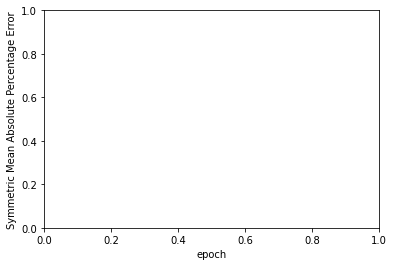

In [77]:
fig,ax=plt.subplots(1,1)
ax.set_xlabel('epoch');ax.set_ylabel('Symmetric Mean Absolute Percentage Error')

x=list(range(1,20+1))

vy = cnn_history.cnn_history['val_loss']
ty = cnn_history.cnn_history['loss']
plt_dynamic(x, vy, ty, ax)